# アミノ酸配列のグラフ表示画像のVision Transformerによるタンパク質ファミリー分類（5分割交差検証）
- グラデーション適用
- クラスごとに分ける `StratifiedKFold` を採用
- ベースモデル：`google/vit-base-patch16-224-in21k`
- ハイパーパラメータ
    - バッチサイズ：$16$
    - エポック数：$40$
    - 学習率：$5 \times 10^{-5}$

## 1. ライブラリのインポート

In [1]:
from torch.utils.data import Dataset, Subset
from PIL import Image
import os
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTImageProcessorFast, ViTForImageClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

label2id = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
id2label = {v: k for k, v in label2id.items()}

MODEL_NAME = "google/vit-base-patch16-224-in21k"
BATCH_SIZE = 16
EPOCHS = 40
LR = 5e-5
# WEIGHT_DECAY = 1e-4

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [2]:
class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "label": label}

## 2. 画像前処理（ViT用）

In [3]:
processor = ViTImageProcessorFast.from_pretrained(MODEL_NAME)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. `Trainer` を使って学習

In [4]:
accuracy = evaluate.load("accuracy")
dataset = GPCRImageDataset("../gpcr_labels.csv", "../graphs/gradation", transform=transform)

# StratifiedKFoldはラベル情報を使う
labels = dataset.data["label"].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[Fold 1 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_26329/2369600214.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.179360,0.956606,0.546585,0.547274,0.546925
2,0.323400,0.139073,0.966969,0.567079,0.561306,0.564033
3,0.124300,0.130860,0.962435,0.546789,0.563390,0.553900
4,0.066800,0.114158,0.970207,0.765996,0.664873,0.698738
5,0.066800,0.126719,0.974741,0.783957,0.768487,0.775701
6,0.042700,0.181827,0.967617,0.783984,0.753388,0.767184
7,0.027700,0.186374,0.959845,0.768549,0.739117,0.752706
8,0.024400,0.187345,0.965674,0.773626,0.758119,0.764470
9,0.024400,0.129080,0.975389,0.781526,0.763310,0.771633
10,0.020900,0.146748,0.973446,0.742514,0.759080,0.747658


Accuracy: 0.9786 | Precision: 0.7828 | Recall: 0.7669 | F1: 0.7744
              precision    recall  f1-score      support
A              0.984112  0.992460  0.988268  1061.000000
B              0.963415  0.868132  0.913295    91.000000
C              0.966495  0.974026  0.970246   385.000000
D              0.000000  0.000000  0.000000     3.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.978627  0.978627  0.978627     0.978627
macro avg      0.782804  0.766924  0.774362  1544.000000
weighted avg   0.976628  0.978627  0.977466  1544.000000


/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

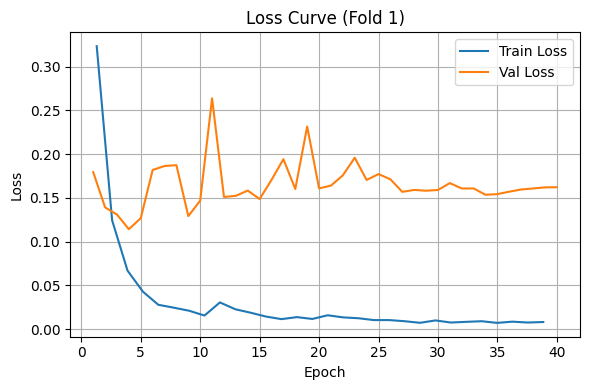

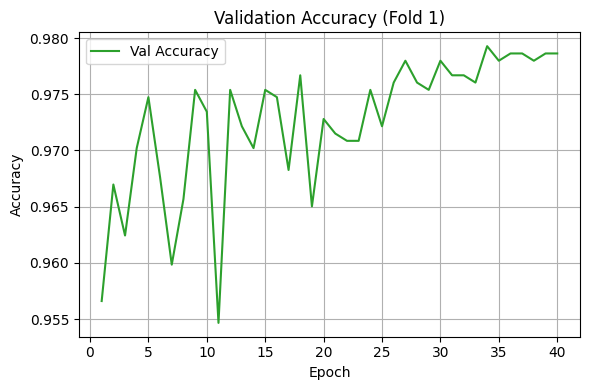

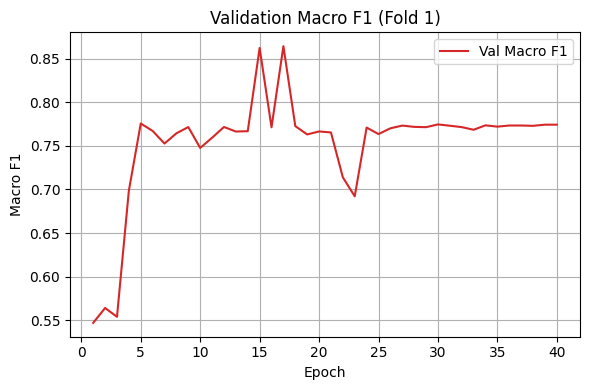

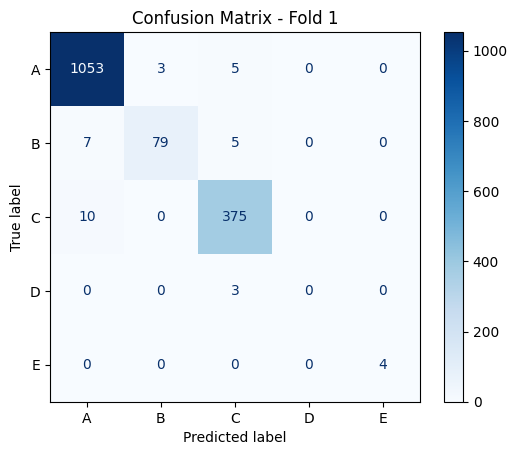

[Fold 2 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_26329/2369600214.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.206036,0.946209,0.565665,0.513154,0.532847
2,0.316200,0.145172,0.963059,0.771812,0.675964,0.714184
3,0.112500,0.145803,0.958522,0.674517,0.652385,0.655049
4,0.076400,0.147638,0.957874,0.606493,0.684021,0.626009
5,0.076400,0.192126,0.961763,0.770679,0.671687,0.712837
6,0.049300,0.205024,0.953986,0.900185,0.812326,0.817674
7,0.036000,0.148364,0.970836,0.765641,0.758555,0.761316
8,0.023800,0.152842,0.965651,0.793716,0.831056,0.786073
9,0.023800,0.197189,0.963707,0.955232,0.808449,0.847486
10,0.029600,0.170275,0.966299,0.902364,0.881179,0.890885


Accuracy: 0.9695 | Precision: 0.8233 | Recall: 0.8844 | F1: 0.8429
              precision    recall  f1-score     support
A              0.986767  0.983977  0.985370  1061.00000
B              0.923077  0.800000  0.857143    90.00000
C              0.939850  0.971503  0.955414   386.00000
D              0.666667  0.666667  0.666667     3.00000
E              0.600000  1.000000  0.750000     3.00000
accuracy       0.969540  0.969540  0.969540     0.96954
macro avg      0.823272  0.884429  0.842919  1543.00000
weighted avg   0.969941  0.969540  0.969320  1543.00000


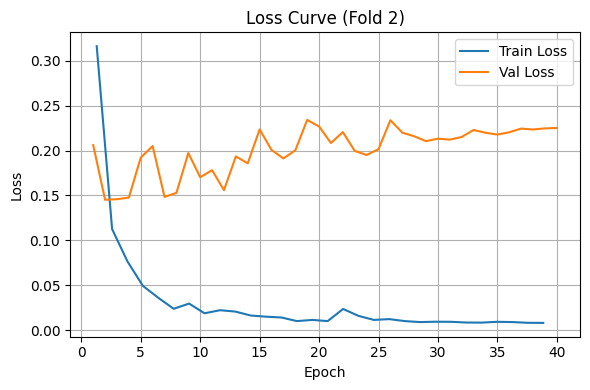

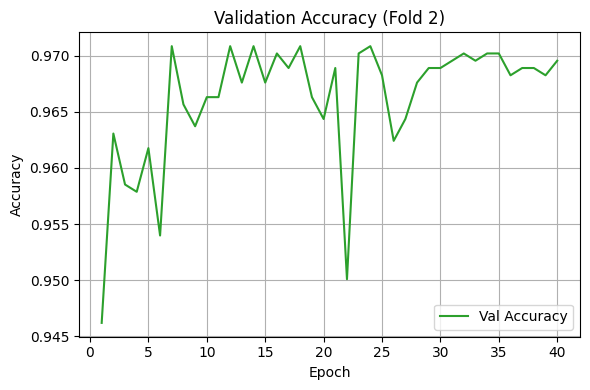

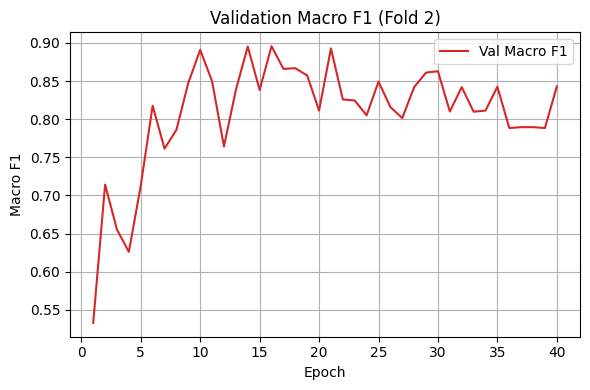

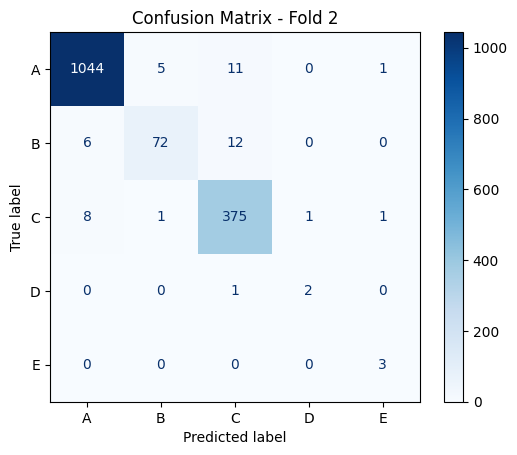

[Fold 3 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_26329/2369600214.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.254063,0.924822,0.555736,0.492583,0.518775
2,0.305700,0.153851,0.957874,0.543721,0.567556,0.554846
3,0.122500,0.156547,0.962411,0.764591,0.696497,0.723856
4,0.064400,0.161165,0.955930,0.738590,0.698331,0.710064
5,0.064400,0.177590,0.968244,0.782853,0.690785,0.729053
6,0.046800,0.191349,0.956578,0.848862,0.764371,0.795326
7,0.030600,0.183251,0.964355,0.762530,0.699072,0.724057
8,0.019200,0.188789,0.968244,0.770262,0.702148,0.729441
9,0.019200,0.199808,0.964355,0.762050,0.697030,0.722871
10,0.019900,0.190996,0.966299,0.757967,0.703624,0.723884


Accuracy: 0.9650 | Precision: 0.7675 | Recall: 0.6979 | F1: 0.7260
              precision    recall  f1-score      support
A              0.973856  0.983962  0.978883  1060.000000
B              0.911111  0.901099  0.906077    91.000000
C              0.952632  0.937824  0.945170   386.000000
D              0.000000  0.000000  0.000000     3.000000
E              1.000000  0.666667  0.800000     3.000000
accuracy       0.965003  0.965003  0.965003     0.965003
macro avg      0.767520  0.697910  0.726026  1543.000000
weighted avg   0.963004  0.965003  0.963905  1543.000000


/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

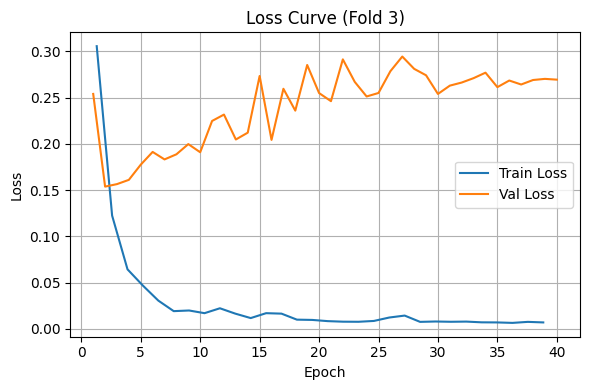

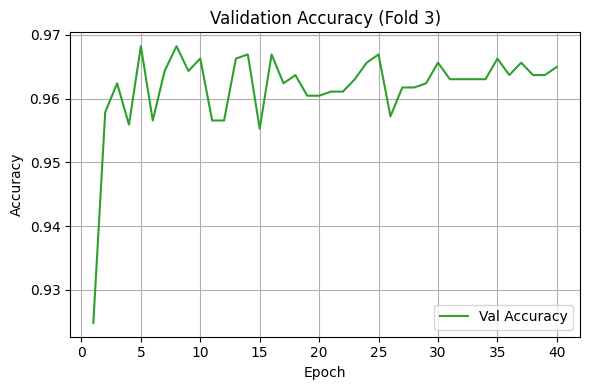

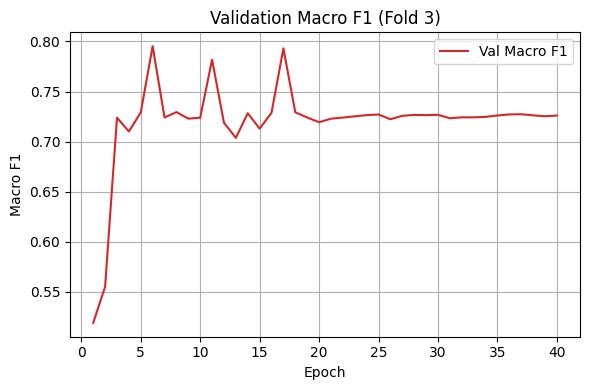

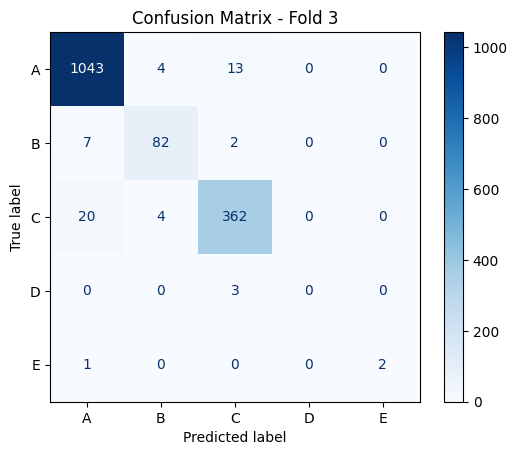

[Fold 4 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_26329/2369600214.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.239512,0.928062,0.508053,0.528016,0.516943
2,0.305800,0.265229,0.933247,0.559977,0.514074,0.534230
3,0.123100,0.139096,0.963059,0.762033,0.604419,0.637738
4,0.070400,0.139781,0.970836,0.776603,0.756117,0.765243
5,0.070400,0.207451,0.955282,0.861437,0.843034,0.850485
6,0.039400,0.179143,0.961763,0.762216,0.754826,0.757971
7,0.031500,0.172059,0.965651,0.774694,0.742256,0.756373
8,0.023200,0.191370,0.964355,0.766569,0.744843,0.753905
9,0.023200,0.157296,0.970188,0.771756,0.750592,0.760306
10,0.022100,0.166911,0.969540,0.761225,0.765785,0.763438


Accuracy: 0.9708 | Precision: 0.7669 | Recall: 0.7595 | F1: 0.7630
              precision    recall  f1-score      support
A              0.986767  0.984906  0.985836  1060.000000
B              0.905882  0.846154  0.875000    91.000000
C              0.941919  0.966321  0.953964   386.000000
D              0.000000  0.000000  0.000000     2.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.970836  0.970836  0.970836     0.970836
macro avg      0.766914  0.759476  0.762960  1543.000000
weighted avg   0.969533  0.970836  0.970085  1543.000000


/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/ssd/GR2025/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

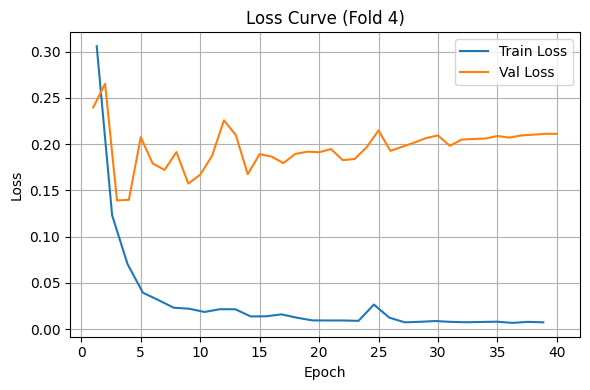

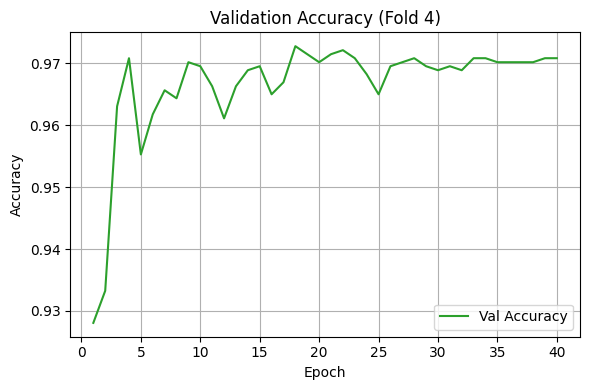

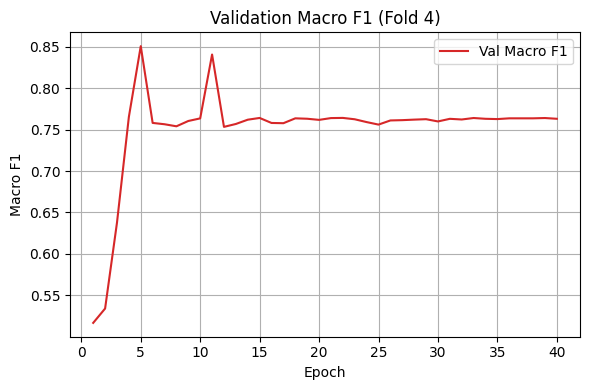

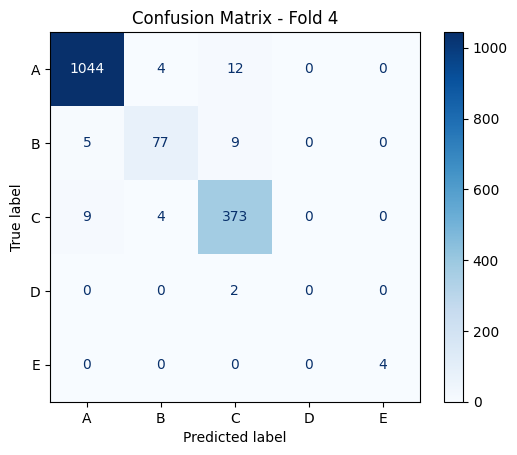

[Fold 5 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_26329/2369600214.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.216774,0.941672,0.558446,0.498844,0.518515
2,0.313500,0.140809,0.958522,0.560031,0.544559,0.550461
3,0.118400,0.137856,0.963707,0.763217,0.591861,0.630466
4,0.082900,0.128237,0.961763,0.711294,0.701784,0.706186
5,0.082900,0.160691,0.965651,0.717892,0.699460,0.707958
6,0.051500,0.156069,0.966299,0.958874,0.755314,0.823409
7,0.024800,0.158224,0.965651,0.888146,0.756838,0.803439
8,0.022600,0.168776,0.965651,0.875233,0.807011,0.837048
9,0.022600,0.199973,0.959819,0.829168,0.786539,0.799380
10,0.020300,0.161583,0.965651,0.870177,0.858172,0.863997


Accuracy: 0.9624 | Precision: 0.8621 | Recall: 0.8529 | F1: 0.8574
              precision    recall  f1-score      support
A              0.972923  0.983019  0.977945  1060.000000
B              0.885057  0.846154  0.865169    91.000000
C              0.952507  0.935233  0.943791   386.000000
D              0.500000  0.500000  0.500000     2.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.962411  0.962411  0.962411     0.962411
macro avg      0.862097  0.852881  0.857381  1543.000000
weighted avg   0.962090  0.962411  0.962187  1543.000000


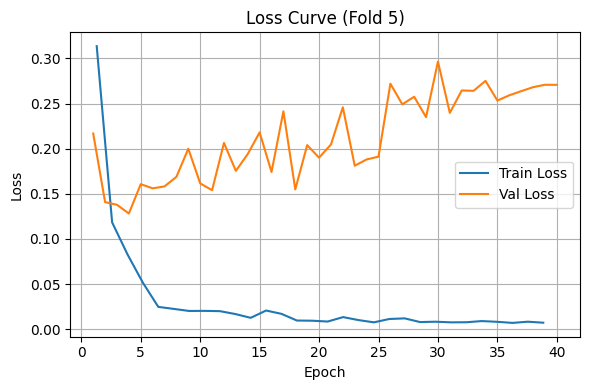

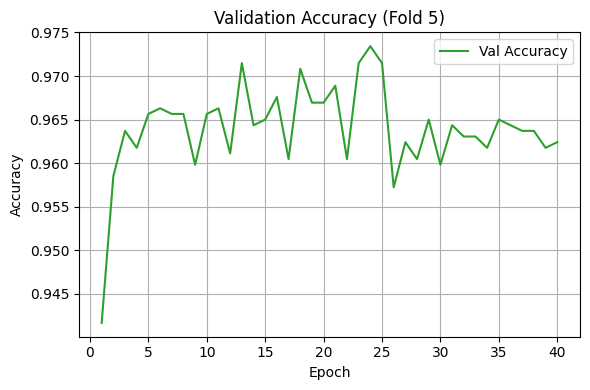

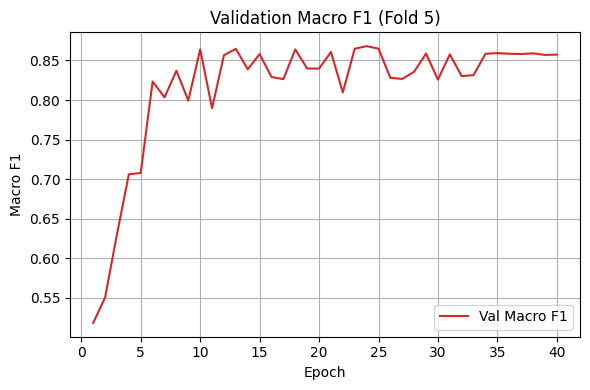

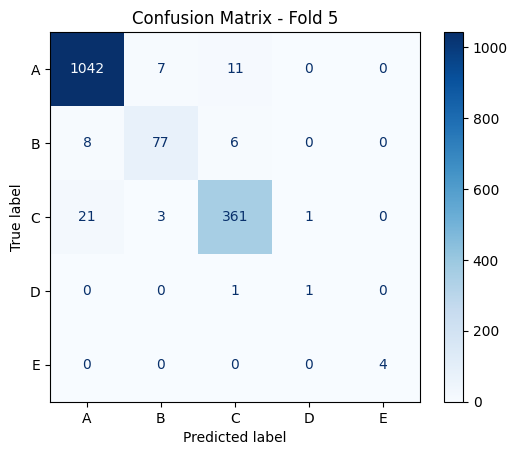

In [6]:
all_accs, all_pres, all_recs, all_f1s = [], [], [], []
all_class_f1s, all_conf_matrices = [], []
all_val_losses, all_val_accs, all_val_f1s = [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\033[34m[Fold {fold+1} / 5]\033[0m")

    # Subset 作成
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # ======================
    # 4. モデル初期化
    # ======================
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=5,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"../models/amino-classification-transformer-vit-google-stratified-kfold/batch-{BATCH_SIZE}-epoch-{EPOCHS}-lr-{LR}/{fold+1}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=EPOCHS,
        logging_dir="./logs",
        report_to="none",
        learning_rate=LR,
        load_best_model_at_end=False
    )

    # ======================
    # 5. 評価指標
    # ======================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        f1 = f1_score(labels, preds, average="macro")
        pre = precision_score(labels, preds, average="macro", zero_division=0)
        rec = recall_score(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1}

    # ======================
    # 6. Trainer実行
    # ======================
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # ==== ログから学習曲線抽出 ====
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.dropna(subset=["epoch"])
    train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]]
    eval_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

    all_val_losses.append(eval_loss["eval_loss"].values)
    all_val_accs.append(eval_loss["eval_accuracy"].values)
    all_val_f1s.append(eval_loss["eval_f1"].values)

    # ======================
    # 7. 推論と評価
    # ======================
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    acc = accuracy.compute(predictions=y_pred, references=y_true)["accuracy"]
    pre = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))

    report = classification_report(y_true, y_pred, target_names=list(label2id.keys()), output_dict=True)
    class_f1 = [report[c]["f1-score"] for c in list(label2id.keys())]

    # ==== 保存 ====
    all_accs.append(acc)
    all_pres.append(pre)
    all_recs.append(rec)
    all_f1s.append(f1)
    all_class_f1s.append(class_f1)
    all_conf_matrices.append(cm)

    # ==== 表示 ====
    print(f"\033[91mAccuracy: {acc:.4f}\033[0m | "
          f"\033[92mPrecision: {pre:.4f}\033[0m | "
          f"\033[93mRecall: {rec:.4f}\033[0m | "
          f"\033[94mF1: {f1:.4f}\033[0m")
    print(pd.DataFrame(report).T)

    # ==== foldごとの学習曲線を可視化 ====
    # --- Loss 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", color="C0")
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Val Loss", color="C1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Accuracy 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_accuracy"], label="Val Accuracy", color="C2")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Macro F1 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_f1"], label="Val Macro F1", color="C3")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title(f"Validation Macro F1 (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 混同行列を可視化
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

## 4. 平均可視化

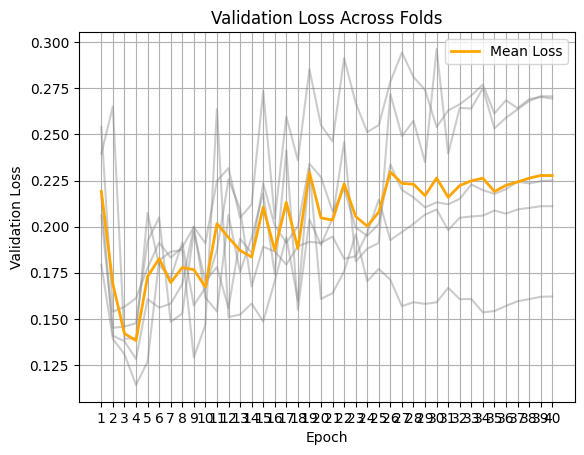

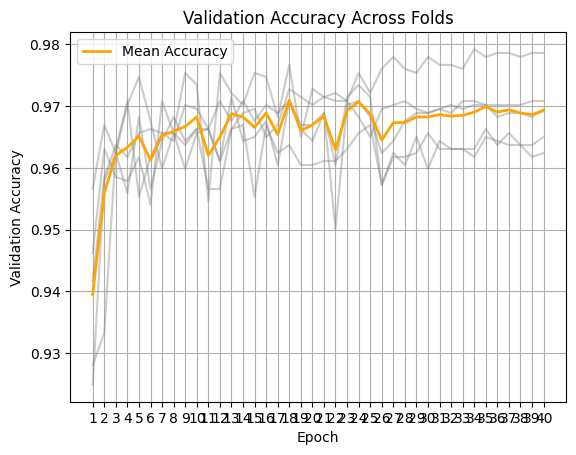

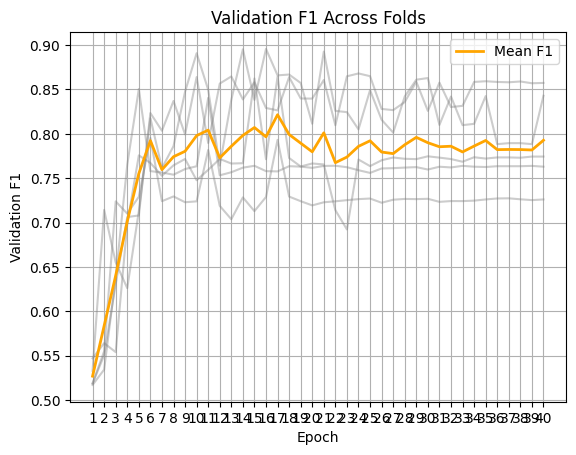

In [7]:
epochs = np.arange(1, EPOCHS + 1)

def interp_to_epochs(arr):
    arr = np.asarray(arr)
    orig_x = np.arange(1, len(arr) + 1)

    if len(arr) == 1:
        return np.full_like(epochs, arr[0], dtype=float)

    return np.interp(epochs, orig_x, arr)

def plot_mean_curves(all_vals, y_label, title, metric_name):
    interp_vals = []

    for v in all_vals:
        v_interp = interp_to_epochs(v)
        interp_vals.append(v_interp)
        plt.plot(epochs, v_interp, color="gray", alpha=0.4)

    interp_vals = np.vstack(interp_vals)
    mean_vals = interp_vals.mean(axis=0)

    plt.plot(epochs, mean_vals, color="orange", linewidth=2, label=f"Mean {metric_name}")
    plt.xlabel("Epoch"); plt.ylabel(y_label); plt.title(title)
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)
    plt.show()

plot_mean_curves(all_val_losses, "Validation Loss", "Validation Loss Across Folds", "Loss")
plot_mean_curves(all_val_accs, "Validation Accuracy", "Validation Accuracy Across Folds", "Accuracy")
plot_mean_curves(all_val_f1s, "Validation F1", "Validation F1 Across Folds", "F1")

## 5. 総合評価


===== Average Across 5 Folds =====
Accuracy : 0.9693
Precision: 0.8005
Recall   : 0.7923
F1       : 0.7927

Per-Class F1 (Macro Average):
  A: 0.9833
  B: 0.8833
  C: 0.9537
  D: 0.2333
  E: 0.9100


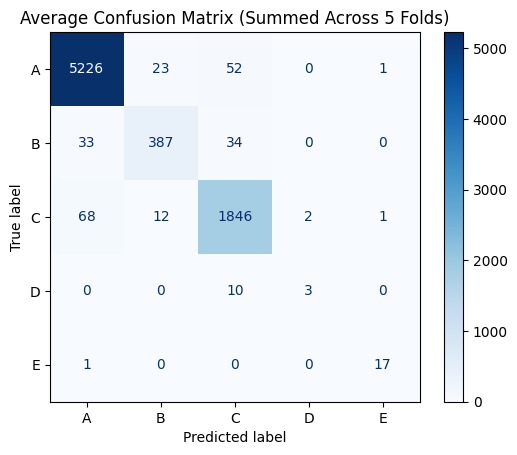

In [8]:
mean_acc = np.mean(all_accs)
mean_pre = np.mean(all_pres)
mean_rec = np.mean(all_recs)
mean_f1 = np.mean(all_f1s)
mean_class_f1 = np.mean(np.array(all_class_f1s), axis=0)

print("\n\033[36m===== Average Across 5 Folds =====\033[0m")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Precision: {mean_pre:.4f}")
print(f"Recall   : {mean_rec:.4f}")
print(f"F1       : {mean_f1:.4f}\n")

print("Per-Class F1 (Macro Average):")
for cls, score in zip(label2id.keys(), mean_class_f1):
    print(f"  {cls}: {score:.4f}")

# ==== 混同行列平均表示 ====
mean_cm = np.sum(all_conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues")
plt.title("Average Confusion Matrix (Summed Across 5 Folds)")
plt.show()